# Notebook for "Random Tree Model of Meaningful Memory"

### Weishun Zhong, Tankut Can, Antonis Georgiou, Ilya Shnayderman, Mikhail Katkov, Misha Tsodyks

## 0. Detect environment

In [ ]:
import sys, subprocess, os

def setup_repo():
    # 1) Detect Colab by presence of the google.colab module
    if 'google.colab' in sys.modules:
        print("🔎 Detected Colab — cloning repo…")
        repo_url = 'https://github.com/zhongweishun/RandomTreeModel_PRL.git'
        # derive the local folder name from the URL
        repo_name = os.path.splitext(repo_url.split('/')[-1])[0]
        
        # 2) Clone (only if missing)
        if not os.path.isdir(repo_name):
            subprocess.run(['git', 'clone', repo_url], check=True)
        
        # 3) If your notebook lives in a subfolder RandomTreeModel_PRL/, cd there
        sub = os.path.join(repo_name, 'RandomTreeModel_PRL')
        if os.path.isdir(sub):
            os.chdir(sub)
            print(f"✅ Switched to notebook folder: {os.getcwd()}")
        else:
            # fallback to repo root
            os.chdir(repo_name)
            print(f"✅ Switched to repo root: {os.getcwd()}")
    else:
        print("💻 Not in Colab — assuming local environment (no git clone)")

setup_repo()


## 1. Simulation (D=4)

### 1(a) Number of nonzero bins

In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import os
import random

# This is the recursive function that generates up to 4 levels of the tree.
def hierarchical_partition(n, k=4):
    
    def partition_step(stars, k):
        if stars == 0:
            return [0] * k
        total_positions = stars + k - 1
        bar_positions = random.sample(range(total_positions), k - 1)
        bar_positions.sort()
        partitions = []
        previous_bar_position = -1
        for bar_position in bar_positions:
            partitions.append(bar_position - previous_bar_position - 1)
            previous_bar_position = bar_position
        partitions.append(total_positions - previous_bar_position - 1)
        return partitions

    # Helper function to check if partitioning was successful
    def partition_successful(partitions):
        non_zero_bins = sum(1 for p in partitions if p > 0)
        return non_zero_bins > 1

    # Step 1: Initial partition
    partitions_1 = partition_step(n, k)

    # Step 2: Partition each bin from level 1 if partitioning was successful
    final_partitions = []

    if partition_successful(partitions_1):
        for part_1 in partitions_1:
            partitions_2 = partition_step(part_1, k)
            
            if partition_successful(partitions_2):
                for part_2 in partitions_2:
                    partitions_3 = partition_step(part_2, k)
                    final_partitions.extend(partitions_3)
            else:
                final_partitions.extend(partitions_2)  # Keep as is
    else:
        final_partitions.extend(partitions_1)
    
    return final_partitions

In [2]:
#obtain avg. curve for different L
k = 4
pts = 10
n_bins = 20
L_pts = np.linspace(10,110,pts,endpoint=False).astype('int')
repeat = int(1e4) #int(1e6)
C_pts = np.zeros([pts,repeat])

# Custom bins: 20 bins ranging from 1 to 20 with length 1 each
bins = np.arange(0, n_bins+1, 1)

for pt in range(pts):
    print('pt=',pt)
    L = L_pts[pt]

    for r in range(repeat):
        partition = np.array(hierarchical_partition(L, k))
        nz_partition = partition[np.where(partition!=0)[0]]
        C_pts[pt,r] = len(nz_partition)

pt= 0
pt= 1
pt= 2
pt= 3
pt= 4
pt= 5
pt= 6
pt= 7
pt= 8
pt= 9


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from fractions import Fraction

# high precition numerics
def factorial(n):
    if n == 0:
        return Fraction(1, 1)
    else:
        return n * factorial(n-1)
    
def binomial(n, k):
    return factorial(n) / (factorial(k) * factorial(n-k))

def C_formula(N,K,D):
    x = 0
    for m in np.arange(1,N+1):
        x += binomial(N,m)*(-1)**(m+1)/binomial(m+K-1,m)**(D-1)
    return float(x*K**(D-1))

In [4]:
C_avg = np.mean(C_pts,axis=-1)
C_theory= [C_formula(N,4,4) for N in np.arange(0,101)]

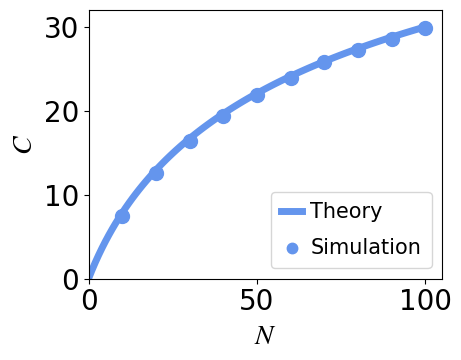

In [5]:
# Use a math font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20

my_blue = np.array([100, 149, 237]) / 255


fig1,ax1 = plt.subplots(figsize=(5,4))
ax1.plot(np.arange(0,101),C_theory,'-',color=my_blue,linewidth=5,label='Theory')
ax1.scatter(L_pts,C_avg,color=my_blue,s=100,label='Simulation')

ax1.set_xlabel('$N$')
ax1.set_ylabel('$C$')

ax1.set_ylim([0,32])
ax1.set_xlim([0,105])

ax1.legend(
    fontsize=0.75 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.75,         # Scale down marker size in legend
    labelspacing=0.75,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)

plt.tight_layout()
# fig1.savefig('C_theory_vs_sim.pdf')

### 1(b) Chunk size distributions

In [6]:
#obtain avg. curve for different L
k = 4
pts = 5
# bins = np.arange(1,21,1)

L_pts = np.linspace(20,120,pts,endpoint=False).astype('int')
repeat = int(1e4) #int(1e5)

dist_all_fig1 = []

for pt in range(pts):
    print('pt=',pt)
    L = L_pts[pt]
    all_partitions = []

    for r in range(repeat):
        partition = np.array(hierarchical_partition(L, k))
        all_partitions.extend(partition)

    dist_all, bin_edges_fig1 = np.histogram(all_partitions, bins=np.arange(1,L+1,1), density=True)
    dist_all_fig1.append(dist_all)


pt= 0
pt= 1
pt= 2
pt= 3
pt= 4


In [7]:
def P_formula(n,N,K,D):
    x = 0
    for m in np.arange(n,N+1):
        x += (-1)**(m+n)/binomial(m+K-1,m)**(D-1) * binomial(N,m)*binomial(m,n)
    return float(x)

In [8]:
p4_theory_fig1= []

for pt in range(len(L_pts)):
    print('pt=',pt)
    L = int(L_pts[pt])
    p4_theory = np.array([P_formula(n4,L,4,4) for n4 in np.arange(0,L+1,1)])
    
    #re-normalize for the non-zero bins
    p4_theory_renorm = p4_theory[1:]/(1-p4_theory[0])
    p4_theory_fig1.append(p4_theory_renorm)

pt= 0
pt= 1
pt= 2
pt= 3
pt= 4


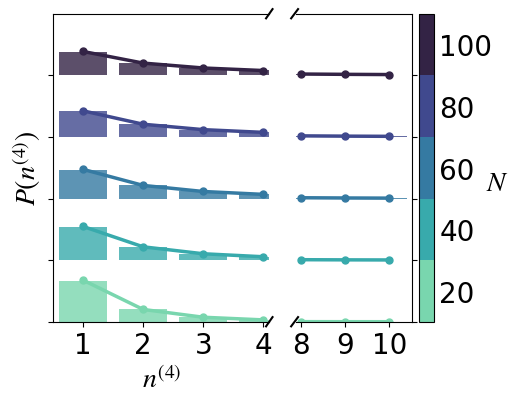

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import numpy as np


# Setup figure and gridspec
fig = plt.figure(figsize=(5, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2], wspace=0.15)

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharey=ax)

# Create a list of colors using the reversed 'mako' colormap
colors = sns.color_palette("mako_r", n_colors=len(L_pts))
custom_cmap = ListedColormap(colors)

delta_L = L_pts[1] - L_pts[0]

# Create boundaries for the discrete colormap
mid_points = (L_pts[:-1] + L_pts[1:]) / 2
boundaries = np.concatenate((
    [L_pts[0] - delta_L / 2],
    mid_points,
    [L_pts[-1] + delta_L / 2]
))

# Create a BoundaryNorm
norm = BoundaryNorm(boundaries=boundaries, ncolors=len(colors))

# Create ScalarMappable
sm = ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Necessary to 'fake' the ScalarMappable having data

# Specify ticks you want to display on the colorbar
specified_ticks = L_pts
specified_tick_labels = [f'{int(tick)}' for tick in specified_ticks]

# Create colorbar
cbar = plt.colorbar(sm, ax=ax1, ticks=specified_ticks, boundaries=boundaries, spacing='uniform')
cbar.set_ticklabels(specified_tick_labels)
cbar.set_label('$N$', rotation=0)
cbar.ax.minorticks_off()
cbar.ax.tick_params(which='both', length=0)

# Determine the maximum y-value for scaling
max_y = 1 #max([max(np.max(p3_theory[pt]), np.max(dist_all[pt])) for pt in range(pts)])
spacing = max_y * 1  # Adjust the spacing between ridges

for pt in range(pts):
    # Calculate the offset
    offset = pt * spacing

    # Shift data by offset
    y_theory = p4_theory_fig1[pt] + offset
    y_simulation = dist_all_fig1[pt] + offset
    x_data = np.arange(1, 21, 1)

    # Plot the theoretical line
    ax.plot(x_data[:4], y_theory[:4], '-o', color=colors[pt], linewidth=2.5, markersize=5,
            label='Theory' if pt == 0 else "")

    ax1.plot(x_data[7:10], y_theory[7:10], '-o', color=colors[pt], linewidth=2.5, markersize=5,
             label='Theory' if pt == 0 else "")

    # Plot the empirical histogram as a bar plot with appropriate offset
    ax.bar(x_data[:4], y_simulation[:4] - offset, width=0.8,
           color=colors[pt], alpha=0.8, bottom=offset,
           label='Simulation' if pt == 0 else "")

    if pt ==0:
        y_simulation = np.insert(y_simulation,-1,0)

    ax1.bar(x_data[7:10], y_simulation[7:10] - offset, width=0.8,
            color=colors[pt], alpha=0.8, bottom=offset,
            label='Simulation' if pt == 0 else "")
    
# Adjust plot aesthetics
ax.set_xlabel(r'$n^{(4)}$')
ax.set_ylabel(r'$P(n^{(4)})$')
ax.set_xlim(0.5,4.1)
ax.set_xticks(np.arange(1,5,1))
# ax.set_yticks([])  # Comment out this line to show y-axis ticks

# Set y-limits based on the data
ax.set_ylim(0, pts * spacing)

# Set y-ticks at each offset
yticks = np.arange(0, pts * spacing, spacing)
ax.set_yticks(yticks)

# Hide y-axis tick labels but show tick marks on ax
ax.tick_params(axis='y', which='both', labelleft=False)

ax1.set_xlim(7.9,10.5)
ax1.set_xticks([8,9,10])
# ax1.set_yticks([])  # Remove this line to avoid affecting shared y-axis

# Hide y-axis ticks and labels on ax1 without affecting ax
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

# Hide the spines between ax and ax1
ax.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labeltop=False)  # Hide the top tick labels on ax
ax1.yaxis.tick_right()

# For ax1, hide y-axis tick labels
for label in ax1.get_yticklabels():
    label.set_visible(False)

# Adding diagonal lines to indicate the break
d = .015  # Size of diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax1.transAxes)  # Update kwargs for the second axes
ax1.plot((-d*3, +d), (1-d, 1+d), **kwargs)
ax1.plot((-d*3, +d), (-d, +d), **kwargs)
# fig.savefig('chunk_size_distributions_split_review.pdf')


## 2. Experimental Data

In [10]:
import os
import glob
import numpy as np
import pandas as pd
import json

dr = os.getcwd()

In [11]:
import numpy as np

story_names = np.array(['schissel_v1-pool', 'schissel_v2-lake', 'boyscout',
       'triplett_v2-catlady', 'triplett_v1-rookie', 'hester_v1-park',
       'doSomething', 'hester_v2-church', 'stein', 'bear', 'youngest'],
      dtype='<U32')

L_data = np.array([ 18,  18,  19,  32,  32,  54,  81,  54, 130, 122, 194])

In [12]:
import ast

def get_empirical_M_and_C(df):

    
    df_non_zero_fanout = df[df['fan_out'] != 0].copy()

    # Get the maximum clause_id for each recall_id (subject)
    max_clause_ids = df_non_zero_fanout.groupby('recall_id')['clause_id'].max().reset_index()
    max_clause_ids_array = max_clause_ids['clause_id'].values

    # # Get the indices that would sort the max_clause_ids_array
    # subject_inds = np.argsort(max_clause_ids_array)

    # # Get the recall_ids in the order specified by subject_inds
    # subject_recall_ids = max_clause_ids['recall_id'].values[subject_inds]

    # Get the recall_ids in the order specified by subject_inds
    subject_recall_ids = max_clause_ids['recall_id'].values

    # Get the indices that would sort the subject_recall_ids
    subject_inds = np.argsort(subject_recall_ids)

    M_empirical = []

    # Loop over the subjects in your specified order
    for subject in subject_recall_ids:
        # Filter the data for the current subject
        subject_data = df_non_zero_fanout[df_non_zero_fanout['recall_id'] == subject]

        # Initialize an array filled with NaNs for missing values
        subject_array = []

        # Fill in the fan_out values at the corresponding clause_id positions
        for idx, row in subject_data.iterrows():
            clause_id = int(row['clause_id']) - 1  # Adjust index to start from 0
            segments = np.array(row['segment_ids'])
            try:
                subject_array.extend(segments)
            except TypeError:
                segments_str = segments.item()
                segments_list = ast.literal_eval(segments_str)
                subject_array.extend(segments_list)
                
        M_empirical.append(len(set(subject_array)))

    return M_empirical, max_clause_ids_array[subject_inds]

def get_mean_and_error_GPT4(dr_data):

    M_recall_all= []
    C_recall_all = []
    L_recall_all = []

    for i in range(len(L_data)):
        story = story_names[i]
        L = L_data[i]
        print(story)

        if story == 'doSomething':
            df_story = pd.read_csv(dr_data + story + '/clauses_to_segments_set.csv', encoding='latin1')
        else:
            df_story = pd.read_csv(dr_data + story + '/clauses_to_segments_set.csv')

        M_recall,C_recall = get_empirical_M_and_C(df_story)
        M_recall_all.append(M_recall)
        C_recall_all.append(C_recall)
        L_recall_all.append(L*np.ones(len(M_recall)))

    M_data = np.zeros(len(L_data))
    M_error = np.zeros(len(L_data))
    C_data = np.zeros(len(L_data))
    C_error = np.zeros(len(L_data))

    for i in range(len(L_data)):
        M_data[i] = np.mean(M_recall_all[i])
        M_error[i] = np.std(M_recall_all[i])/np.sqrt(len(M_recall_all[i]))
        C_data[i] = np.mean(C_recall_all[i])
        C_error[i] = np.std(C_recall_all[i])/np.sqrt(len(C_recall_all[i]))

    return M_data, M_error, C_data, C_error, M_recall_all, C_recall_all

def get_mean_and_error(dr_data):

    M_recall_all= []
    C_recall_all = []
    L_recall_all = []

    for i in range(len(L_data)):
        story = story_names[i]
        L = L_data[i]
        print(story)

        df_story = pd.read_csv(dr_data + story + '.csv')
        M_recall,C_recall = get_empirical_M_and_C(df_story)
        M_recall_all.append(M_recall)
        C_recall_all.append(C_recall)
        L_recall_all.append(L*np.ones(len(M_recall)))

    M_data = np.zeros(len(L_data))
    M_error = np.zeros(len(L_data))
    C_data = np.zeros(len(L_data))
    C_error = np.zeros(len(L_data))

    for i in range(len(L_data)):
        M_data[i] = np.mean(M_recall_all[i])
        M_error[i] = np.std(M_recall_all[i])/np.sqrt(len(M_recall_all[i]))
        C_data[i] = np.mean(C_recall_all[i])
        C_error[i] = np.std(C_recall_all[i])/np.sqrt(len(C_recall_all[i]))

    return M_data, M_error, C_data, C_error, M_recall_all, C_recall_all


In [13]:
dr_data_GPT4 = dr + '/data/Recall_mappings/'
M_data, M_error, C_data, C_error, M_recall_all, C_recall_all = get_mean_and_error_GPT4(dr_data_GPT4)

schissel_v1-pool
schissel_v2-lake
boyscout
triplett_v2-catlady
triplett_v1-rookie
hester_v1-park
doSomething
hester_v2-church
stein
bear
youngest


In [14]:
bins_fixed = np.arange(1,21,1)
data_inds = np.argsort(M_data)

L_data = L_data[data_inds]
M_data = M_data[data_inds]
M_error = M_error[data_inds]
C_data = C_data[data_inds]
C_error = C_error[data_inds]
M_recall_all = [np.array(M_recall_all[i])[data_inds] for i in range(len(M_recall_all))]

### 2(a). L vs N

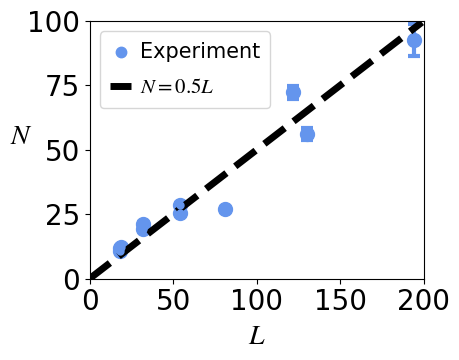

In [15]:
# Use a math font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20

# plot M_data vs L_data
fig, ax = plt.subplots(figsize=(5, 4))

# Create a scatter plot
ax.scatter(L_data, M_data, color=my_blue, s=100,label='Experiment')

# error bar
for i in range(len(L_data)):
    ax.errorbar(L_data[i], M_data[i], yerr=M_error[i], linestyle="None", fmt='o',linewidth=3, markersize=3,capsize=4,markeredgewidth=3,color=my_blue)

ax.plot(np.arange(0,200),0.5*np.arange(0,200),'--',color='black',linewidth=5,label=r'$N=0.5L$')

ax.set_xlabel('$L$')
ax.set_ylabel('$N$',rotation=0)
ax.legend(loc='upper left')
ax.set_xlim(0, 200)
ax.set_ylim(0, 100)

ax.legend(
    fontsize=0.75 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.75,         # Scale down marker size in legend
    labelspacing=0.75,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)

plt.tight_layout()

# fig.savefig('M_vs_L.pdf')

### 2(b). C vs N

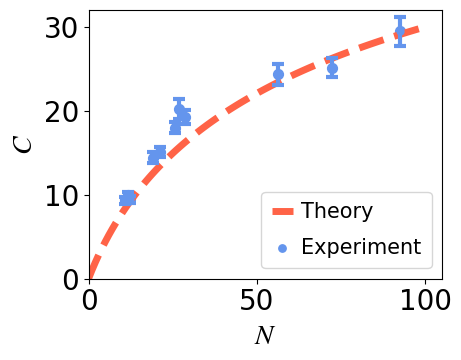

In [16]:
# Use a math font
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20

my_red = np.array([255, 99, 71]) / 255
my_blue = np.array([100, 149, 237]) / 255
my_green = '#42f5b3'

fig1,ax1 = plt.subplots(figsize=(5,4))

ax1.plot(np.arange(0,101),C_theory,'--',color=my_red,linewidth=5,label='Theory')
ax1.scatter(M_data,C_data,s=50,color=my_blue,label='Experiment')
ax1.errorbar(M_data,C_data,yerr = C_error, linestyle="None", fmt='o',linewidth=3, markersize=3,capsize=4,markeredgewidth=3,color=my_blue)

ax1.set_xlabel('$N$')
ax1.set_ylabel('$C$')
ax1.set_ylim([0,32])
ax1.set_xlim([0,105])

# set y-ticks
ax1.set_yticks([0,10,20,30])


ax1.legend(
    fontsize=0.75 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.75,         # Scale down marker size in legend
    labelspacing=0.75,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)

plt.tight_layout()
# fig1.savefig('C_theory_vs_data.pdf')

### 2(c). Chunk size distributions

In [17]:
def get_data_dist(i):
    M = int(np.rint(M_data[i]))
    story = story_names[i]
    if story == 'doSomething':
        df_story = pd.read_csv(dr_data_GPT4 + story + '/clauses_to_segments_set.csv', encoding='latin1')
    else:
        df_story = pd.read_csv(dr_data_GPT4 + story + '/clauses_to_segments_set.csv')
    rank_all = df_story.to_numpy()[:,3]
    max_clause_ids = df_story.groupby('recall_id')['clause_id'].max().reset_index()
    max_clause_ids_array = max_clause_ids['clause_id'].values
    
    hist, bin_edges = np.histogram(rank_all, bins=np.arange(1,M+1,1), density=True)

    return hist, bin_edges, max_clause_ids_array

def plot_data_hist(ax, hist, bin_edges,color):
    blue = np.array([100, 149, 237]) / 255
    ax.scatter(bin_edges[:-1], hist, color=color, alpha=0.8, label='data') 

def plot_theory_hist(ax, hist, bin_edges,color):
    red = np.array([255, 99, 71]) / 255
    ax.plot(bin_edges[:-1], hist, color=color, label='model')


In [18]:
matplotlib.rcParams.update({'font.size': 20})

C_subject_all = []
hist_data_all = []
bin_edges_all_fig2 = []

for i in range(len(M_data)):
    hist_data, bin_edges, C_subject = get_data_dist(i)
    C_subject_all.append(C_subject)
    hist_data_all.append(hist_data)
    bin_edges_all_fig2.append(bin_edges)

p4_theory_vs_data_fig2 = []

for pt in range(len(M_data)):
    print('pt=',pt)
    M = int(np.rint(M_data[pt]))

    p4_theory = np.array([P_formula(n4,M,4,4) for n4 in np.arange(0,M+1,1)])
    
    #re-normalize for the non-zero bins
    p4_theory_renorm = p4_theory[1:]/(1-p4_theory[0])
    p4_theory_vs_data_fig2.append(p4_theory_renorm)


pt= 0
pt= 1
pt= 2
pt= 3
pt= 4
pt= 5
pt= 6
pt= 7
pt= 8
pt= 9
pt= 10


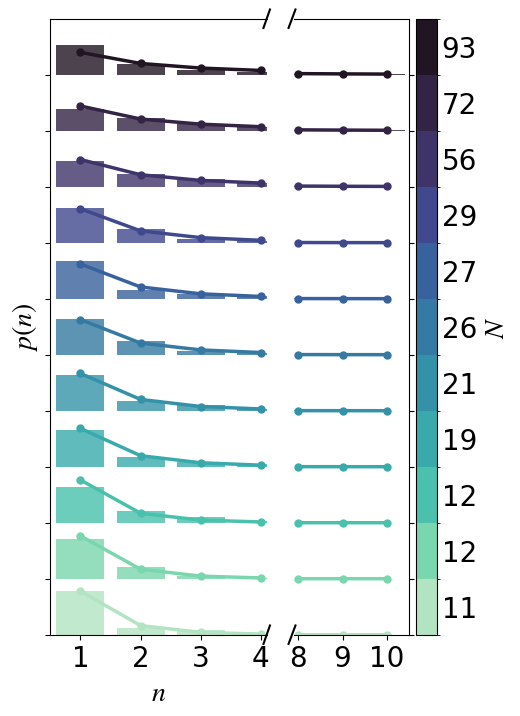

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec  # Import gridspec

# Set Matplotlib parameters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 20

# Create figure and gridspec
# fig = plt.figure(figsize=(5, 6.4))
fig = plt.figure(figsize=(5, 8))

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2], wspace=0.15)

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharey=ax)

# # Create a list of colors using the 'Paired' colormap
# colors = sns.color_palette("Paired", n_colors=len(M_data)+1)

# # Remove the color before the last
# del colors[-2]

# Create a list of colors using the reversed 'mako' colormap
colors = sns.color_palette("mako_r", n_colors=len(M_data))
custom_cmap = ListedColormap(colors)

# Create a list of colors using the reversed 'blues' colormap
# color_values = np.linspace(0.3, 1, len(M_data))
# colors = plt.cm.Blues(color_values)
# custom_cmap = ListedColormap(colors)

# Set up the colorbar with the custom colormap
norm = BoundaryNorm(boundaries=np.arange(-0.5, len(M_data)+0.5, 1), ncolors=custom_cmap.N)

# Create a ScalarMappable and use our custom colormap and norm
sm = ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # Necessary for ScalarMappable

# Adding the colorbar to the figure with customized ticks and labels
cbar = plt.colorbar(sm, ax=ax1, ticks=np.arange(0, len(M_data)), shrink=1, aspect=30)
cbar.set_label('$N$')
cbar.set_ticklabels([int(np.rint(M_data[i])) for i in range(len(M_data))])

# Remove tick marks on the colorbar
cbar.ax.tick_params(size=0)  # Set the tick size to zero to remove tick marks

# Determine the maximum y-value for scaling
max_y = 1  # Adjust based on your data
spacing = max_y * 1  # Adjust the spacing between ridges

# Plotting loop
for pt in range(len(M_data)):
    # Calculate the offset
    offset = pt * spacing

    # Shift the data by the offset
    y_theory = p4_theory_vs_data_fig2[pt] + offset
    y_simulation = hist_data_all[pt] + offset  # Adjusted to include offset
    x_data = bin_edges_all_fig2[pt]

    # Plot the theoretical line
    ax.plot(x_data[:4], y_theory[:4], '-o', color=colors[pt], linewidth=2.5, markersize=5,
            label='Theory' if pt == 0 else "")

    ax1.plot(x_data[7:10], y_theory[7:10], '-o', color=colors[pt], linewidth=2.5, markersize=5,
             label='Theory' if pt == 0 else "")

    # Plot the empirical histogram as a bar plot with appropriate offset
    ax.bar(x_data[:4], y_simulation[:4] - offset, width=0.8,
           color=colors[pt], alpha=0.8, bottom=offset,
           label='Simulation' if pt == 0 else "")

    if pt ==0:
        y_simulation = np.insert(y_simulation,-1,0)

    ax1.bar(x_data[7:10], y_simulation[7:10] - offset, width=0.8,
            color=colors[pt], alpha=0.8, bottom=offset,
            label='Simulation' if pt == 0 else "")

# Adjust plot aesthetics
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$p(n)$')
ax.set_xlim(0.5, 4.1)
ax.set_xticks(np.arange(1, 5, 1))
# Remove the line that hides all y-axis ticks
# ax.set_yticks([])  # Commented out to show y-axis ticks

ax1.set_xlim(7.9, 10.5)
ax1.set_xticks([8, 9, 10])
# ax1.set_yticks([])  # Commented out to prevent affecting shared y-axis

# Set y-limits based on the data
ax.set_ylim(0, len(M_data) * spacing)

# Set y-ticks at each offset
yticks = np.arange(0, len(M_data) * spacing, spacing)
ax.set_yticks(yticks)

# Hide y-axis tick labels but show tick marks on ax
ax.tick_params(axis='y', which='both', labelleft=False)

# Hide y-axis ticks and labels on ax1 without affecting ax
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

# Hide the spines between ax and ax1
ax.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labeltop=False)  # Hide the top tick labels on ax
ax1.yaxis.tick_right()

# Adding diagonal lines to indicate the break
d = .015  # Size of diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax1.transAxes)  # Update kwargs for the second axes
ax1.plot((-d * 3, +d), (1 - d, 1 + d), **kwargs)
ax1.plot((-d * 3, +d), (-d, +d), **kwargs)

plt.show()
# fig.savefig('chunk_size_distributions_data.pdf')


## 3. Asymptotic distribution

### 3(a). Scaling function

In [20]:
from scipy.integrate import dblquad

def integrand(s1, s2, s3, k):
    term1 = 1 / (s1 * s2)
    term2 = (1 - s3 / s2) ** (k - 2)
    term3 = (1 - s2 / s1) ** (k - 2)
    term4 = (1 - s1) ** (k - 2)
    return term1 * term2 * term3 * term4

def compute_P(s3, k):
    # Define the inner function for dblquad
    def integrand_dblquad(s1, s2):
        return integrand(s1, s2, s3, k)
    
    # Limits for s2: from s3 to 1
    # Limits for s1: from s2 to 1
    result, error = dblquad(
        integrand_dblquad,
        s3, 1,                  # s2 limits
        lambda s2: s2,          # s1 lower limit depends on s2
        lambda s2: 1            # s1 upper limit
    )
    P_s3 = (k - 1) ** 3 * result
    return P_s3


In [21]:
s3_pts = np.linspace(0,1,1000)
invariant_curve = [compute_P(s3, 4) for s3 in s3_pts]

c:\Users\wilso\anaconda3\envs\py38\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


### 3(b). Simulation distributions

In [22]:
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable

def get_sim_dist(M, repeat=5000):

    def hierarchical_partition(n, k=4):
        
        def partition_step(stars, k):
            if stars == 0:
                return [0] * k
            total_positions = stars + k - 1
            bar_positions = random.sample(range(total_positions), k - 1)
            bar_positions.sort()
            partitions = []
            previous_bar_position = -1
            for bar_position in bar_positions:
                partitions.append(bar_position - previous_bar_position - 1)
                previous_bar_position = bar_position
            partitions.append(total_positions - previous_bar_position - 1)
            return partitions

        # Helper function to check if partitioning was successful
        def partition_successful(partitions):
            non_zero_bins = sum(1 for p in partitions if p > 0)
            return non_zero_bins > 1

        # Step 1: Initial partition
        partitions_1 = partition_step(n, k)

        # Step 2: Partition each bin from level 1 if partitioning was successful
        final_partitions = []

        if partition_successful(partitions_1):
            for part_1 in partitions_1:
                partitions_2 = partition_step(part_1, k)
                
                if partition_successful(partitions_2):
                    for part_2 in partitions_2:
                        partitions_3 = partition_step(part_2, k)
                        final_partitions.extend(partitions_3)
                else:
                    final_partitions.extend(partitions_2)  # Keep as is
        else:
            final_partitions.extend(partitions_1)
        
        return final_partitions
    
    
    all_partitions = []

    for r in range(repeat):
        partition = np.array(hierarchical_partition(M))
        nz_partition = partition[np.where(partition!=0)[0]]
        # all_partitions.extend(nz_partition)
        all_partitions.extend(partition)

    dist, bin_edges = np.histogram(all_partitions, bins=np.arange(0,M,1), density=True) #np.arange(0,21,1)

    return dist, bin_edges

pts = 20

# log space from 10 to 1000, 10 points
M_pts_fig3 = np.logspace(1,2,pts).astype('int')

dist_all_fig3 = []
bin_edges_all_fig3 = []

for i in range(len(M_pts_fig3)):
    M = M_pts_fig3[i]
    hist_sim, bin_edges = get_sim_dist(int(M), repeat=int(1e3*M)) #1e4 ~30mins #1e3 ~3mins

    dist_all_fig3.append(hist_sim)
    bin_edges_all_fig3.append(bin_edges)

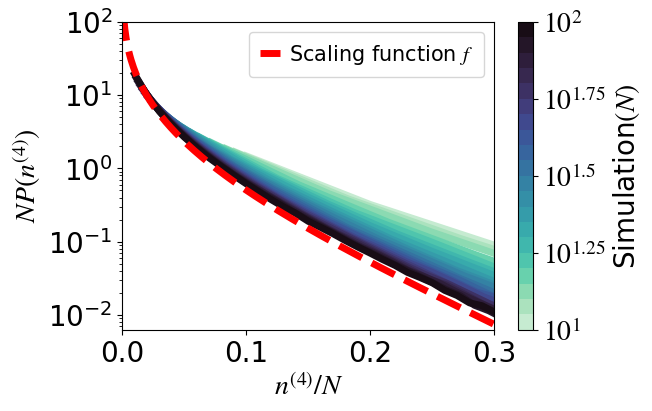

In [23]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
from matplotlib.ticker import LogLocator, FixedLocator, FixedFormatter, NullFormatter
from matplotlib.ticker import FixedLocator, NullLocator, FuncFormatter


def plot_sim_hist_log(ax, hist, bin_edges, color, i):
    # ax.plot(bin_edges[1:-1], np.log(hist[1:]), linewidth=2, color=color)
    ax.semilogy(bin_edges[1:-1], hist[1:], linewidth=5, color=color)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# color_values = np.linspace(0.3, 1, pts)
# colors = plt.cm.Blues(color_values)
# custom_cmap = ListedColormap(colors)

colors = sns.color_palette("mako_r", n_colors=len(M_pts_fig3))
# colors = sns.color_palette("Spectral", n_colors=len(M_pts_fig3))
custom_cmap = ListedColormap(colors)

# Set up the colorbar with the custom colormap and LogNorm
norm = LogNorm(vmin=M_pts_fig3[0], vmax=M_pts_fig3[-1])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])

# Add the colorbar to the plot
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Simulation' + r'$(N)$', rotation=90)

# Specify the tick positions and labels
tick_positions = [10**1, 10**1.25, 10**1.5, 10**1.75, 10**2]
tick_labels = [r'$10^1$', r'$10^{1.25}$', r'$10^{1.5}$', r'$10^{1.75}$', r'$10^2$']

# Set the colorbar to logarithmic scale
cbar.ax.set_yscale('log')

# Use FixedLocator and FixedFormatter for custom ticks and labels
cbar.ax.yaxis.set_major_locator(FixedLocator(tick_positions))
cbar.ax.yaxis.set_major_formatter(FixedFormatter(tick_labels))

# **Disable minor ticks on the colorbar**
cbar.ax.yaxis.set_minor_locator(NullLocator())


for i in range(len(M_pts_fig3)):
    M = M_pts_fig3[i]
    hist_sim = dist_all_fig3[i]  
    bin_edges = bin_edges_all_fig3[i]  

    plot_sim_hist_log(ax, M * hist_sim[:-1], bin_edges[:-1] / M, colors[i], i)

# Plot the theoretical line (ensure 'fanout_pts_theory' and 'asymp_dist_theory' are defined)
# ax.plot(np.array(fanout_pts_theory) / 1000, np.log(1000 * np.array(asymp_dist_theory)),
#         ls='dashed', linewidth=5, color='red', label='Theory' + r'$(M \to \infty)$')

# ax.plot(np.array(fanout_pts_theory_with_zero) / 1001, np.log(1001 * np.array(asymp_dist_theory_with_zero)),
#         ls='dashed', linewidth=5, color='red', label='Theory' + r'$(M \to \infty)$')

# ax.plot(s3_pts[1:], np.log(invariant_curve[1:]), ls='dashed', linewidth=2,color='red', label='Asymptotic Theory')

ax.semilogy(s3_pts[1:], invariant_curve[1:], ls='dashed', linewidth=5,color='red', label='Scaling function '+r'$f$')

# Adjust plot aesthetics
ax.set_xlabel(r'$n^{(4)}/N$')
# ax.set_ylabel('$\ln N p(n^{(4)}/N)$')
ax.set_ylabel('$N P(n^{(4)})$')
# ax.set_ylim([-4.5, 5.5])
ax.set_ylim([10**(-2.2), 10**(2)])
ax.set_xlim([0, 0.3])

# Set major ticks at specific positions
major_ticks = [10**(-2), 10**(-1), 10**0, 10**1, 10**2]
ax.yaxis.set_major_locator(FixedLocator(major_ticks))

# Do not set a custom formatter; use the default formatter for major ticks
# This ensures default font and formatting are used

# Set minor ticks to be dense between the major ticks
subs = np.arange(2, 10) * 0.1  # Subdivisions between powers of 10
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=subs, numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

ax.legend(
    fontsize=0.75 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.75,         # Scale down marker size in legend
    labelspacing=0.75,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)

plt.show()
# fig.savefig('Asymptotic_Distribution_Theory.pdf')

### 3(c). Experimental distributions

C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\wilso\AppData\Local\Temp\ipykernel_41504\3903853001.py:8: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)

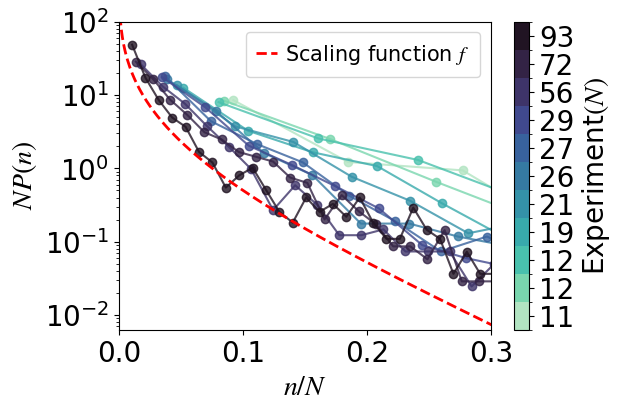

In [24]:
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FixedLocator, FixedFormatter, NullLocator
from matplotlib.ticker import LogLocator, FixedLocator, FixedFormatter, NullFormatter

def plot_data_hist_log(ax, hist, bin_edges,color,i):
    blue = np.array([100, 149, 237]) / 255
    log_hist = np.log(hist)
    log_hist[np.isneginf(log_hist)] = np.nan
    indices = np.arange(len(log_hist))
    valid = ~np.isnan(log_hist)

    # ax.plot(bin_edges[:-1][valid], np.log(hist)[valid],'-o', color=color, alpha=0.8) 
    ax.semilogy(bin_edges[:-1][valid], hist[valid],'-o', color=color, alpha=0.8) 

# colors = plt.cm.Blues(np.linspace(0.3,0.9,len(M_data)))
colors = sns.color_palette("mako_r", n_colors=len(M_data))

fig, ax = plt.subplots(1,1, figsize=(6,4))

# Use the 'tab10' colormap from matplotlib
#colors = plt.cm.tab10(np.arange(8))  # Get the first 8 colors from 'tab10'
custom_cmap = ListedColormap(colors)

# Set up the colorbar with the custom colormap
# Since we're dealing with discrete values, we create a boundary norm with limits for each color
norm = BoundaryNorm(boundaries=np.arange(-0.5, len(M_data)+0.5, 1), ncolors=custom_cmap.N)

# Create a ScalarMappable and use our custom colormap and norm
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm.set_array([])  # This line is often necessary

# Adding the colorbar to the figure with customized ticks and labels
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(0, len(M_data)))
cbar.set_label('Experiment' + r'$(N)$', rotation=90)
cbar.set_ticklabels([int(np.rint(M_data[i])) for i in range(len(M_data))])


for i in range(len(M_data)):
    M = M_data[i]
    hist_data, bin_edges_fig3, C_subject = get_data_dist(i)

    plot_data_hist_log(ax, M*hist_data, bin_edges_fig3/M,colors[i],i)

my_red = np.array([255, 99, 71]) / 255
# ax.plot(s3_pts[1:], np.log(invariant_curve[1:]), ls='dashed', linewidth=2,color='red', label='Scaling function '+r'$f$')
ax.semilogy(s3_pts[1:], invariant_curve[1:], ls='dashed', linewidth=2,color='red', label='Scaling function '+r'$f$')

# ax.plot(np.array(fanout_pts_theory)/1001, np.log(1001*np.array(asymp_dist_theory)), ls='dashed', linewidth=2,color='red', label='Theory' + r'$(M \to \infty)$')
# ax.plot(np.array(fanout_pts_theory)/1001, np.log(1001*np.array(asymp_dist_theory_35)), ls='dashed', linewidth=2,color='green', label='Theory'+r'$(K=3.5)$')

ax.set_xlabel(r'$n/N$')
ax.set_ylabel('$N P(n)$')
ax.set_ylim([10**(-2.2), 10**(2)])
ax.set_xlim([0, 0.3])

# Set major ticks at specific positions
major_ticks = [10**(-2), 10**(-1), 10**0, 10**1, 10**2]
ax.yaxis.set_major_locator(FixedLocator(major_ticks))

# Do not set a custom formatter; use the default formatter for major ticks
# This ensures default font and formatting are used

# Set minor ticks to be dense between the major ticks
subs = np.arange(2, 10) * 0.1  # Subdivisions between powers of 10
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=subs, numticks=100))
ax.yaxis.set_minor_formatter(NullFormatter())  # Hide minor tick labels

ax.legend(
    fontsize=0.75 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
    markerscale=0.75,         # Scale down marker size in legend
    labelspacing=0.75,        # Reduce vertical space between labels
    handlelength=1.0,         # Shorten the length of the legend handles
    handletextpad=0.4,        # Reduce space between legend handle and text
    borderpad=0.5,            # Reduce padding inside the legend box
    borderaxespad=0.5         # Reduce space between legend and axes
)

# fig.savefig('Asymptotic_distribution_data.pdf')

## 4. Show individual data and different K

In [25]:
import ast

def get_empirical_M_and_C(df):

    # Get the maximum clause_id for each recall_id (subject)
    max_clause_ids = df.groupby('recall_id')['clause_id'].max().reset_index()
    max_clause_ids_array = max_clause_ids['clause_id'].values

    # Get the indices that would sort the max_clause_ids_array
    subject_inds = np.argsort(max_clause_ids_array)

    # Get the recall_ids in the order specified by subject_inds
    subject_recall_ids = max_clause_ids['recall_id'].values[subject_inds]

    # Find the maximum clause_id across all subjects
    overall_max_clause_id = df['clause_id'].max()

    # Initialize a list to hold the data arrays for each subject
    data_arrays = []

    M_empirical = []

    # Loop over the subjects in your specified order
    for subject in subject_recall_ids:
        # Filter the data for the current subject
        subject_data = df[df['recall_id'] == subject]
        # Initialize an array filled with NaNs for missing values
        subject_array = []
        # Fill in the fan_out values at the corresponding clause_id positions
        for idx, row in subject_data.iterrows():
            clause_id = int(row['clause_id']) - 1  # Adjust index to start from 0
            segments = np.array(row['segment_ids'])
            try:
                subject_array.extend(segments)
            except TypeError:
                segments_str = segments.item()
                segments_list = ast.literal_eval(segments_str)
                subject_array.extend(segments_list)
                
        M_empirical.append(len(set(subject_array)))

    return M_empirical, max_clause_ids_array[subject_inds]


In [26]:
M_recall_all = []
C_recall_all = []
L_recall_all = []

for i in range(len(M_data)):
    story = story_names[i]
    L = L_data[i]
    print(story)
    if story == 'doSomething':
        df_story = pd.read_csv(dr_data_GPT4 + story + '/clauses_to_segments_set.csv', encoding='latin1')
    else:
        df_story = pd.read_csv(dr_data_GPT4 + story + '/clauses_to_segments_set.csv')
    M_recall,C_recall = get_empirical_M_and_C(df_story)
    M_recall_all.append(M_recall)
    C_recall_all.append(C_recall)
    L_recall_all.append(L*np.ones(len(M_recall)))

M_recall_flatten = np.hstack(M_recall_all)
C_recall_flatten = np.hstack(C_recall_all)
L_recall_flatten = np.hstack(L_recall_all)

schissel_v1-pool
schissel_v2-lake
boyscout
triplett_v2-catlady
triplett_v1-rookie
hester_v1-park
doSomething
hester_v2-church
stein
bear
youngest


In [27]:
num_bins = 10

# Create bins
bins = np.linspace(0, 200, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
averaged_C = np.zeros(num_bins)
error_C = np.zeros(num_bins)

# Compute the average of C_recall_flatten within each bin of M_recall_flatten
for i in range(num_bins):
    # Find indices of M_recall_flatten that fall into the current bin
    indices_in_bin = np.where((M_recall_flatten >= bins[i]) & (M_recall_flatten < bins[i + 1]))[0]
    if indices_in_bin.size > 0:
        bin_values = C_recall_flatten[indices_in_bin]
        averaged_C[i] = np.mean(bin_values)
        error_C[i] = np.std(bin_values, ddof=1) / np.sqrt(indices_in_bin.size)
    else:
        averaged_C[i] = np.nan  # Handle empty bins if necessary
        error_C[i] = np.nan

In [28]:
K2D2 = [C_formula(N,2,2) for N in np.arange(0,210,10)]
K3D3 = [C_formula(N,3,3) for N in np.arange(0,210,10)]
K4D4 = [C_formula(N,4,4) for N in np.arange(0,210,10)]
K5D5 = [C_formula(N,5,5) for N in np.arange(0,210,10)]
K6D6 = [C_formula(N,6,6) for N in np.arange(0,210,10)]

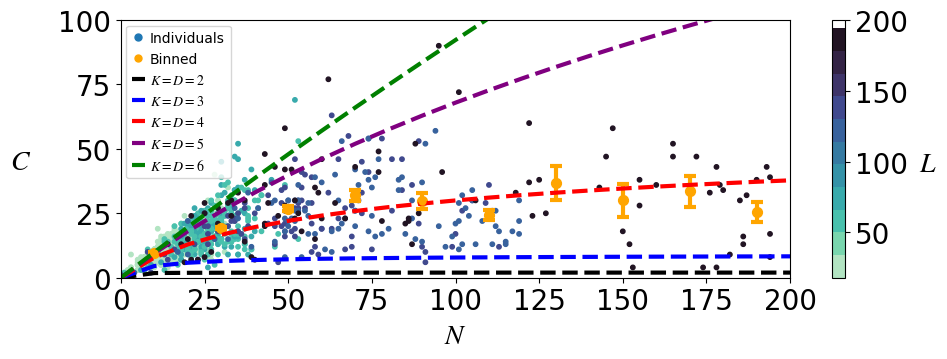

In [29]:
from matplotlib.lines import Line2D

# Create custom legend handles:
handle_sc = Line2D([], [], marker='o', linestyle='None', color='C0',
                     markerfacecolor='C0', markersize=10, label='Individuals')
handle_binned = Line2D([], [], marker='o', linestyle='None', color='orange',
                       markersize=10, label='Binned')
handle_K2D2 = Line2D([], [], linestyle='dashed', color='black', linewidth=3, label='$K=D=2$')
handle_K3D3 = Line2D([], [], linestyle='dashed', color='blue', linewidth=3, label='$K=D=3$')
handle_K4D4 = Line2D([], [], linestyle='dashed', color='red', linewidth=3, label='$K=D=4$')
handle_K5D5 = Line2D([], [], linestyle='dashed', color='purple', linewidth=3, label='$K=D=5$')
handle_K6D6 = Line2D([], [], linestyle='dashed', color='green', linewidth=3, label='$K=D=6$')

# Plotting your data and curves:
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 20

color_values = np.linspace(0.3, 1, len(M_data))
colors = sns.color_palette("mako_r", n_colors=len(M_data))
cmap = ListedColormap(colors)

fig1, ax1 = plt.subplots(figsize=(10,4))

scatter = ax1.scatter(M_recall_flatten, C_recall_flatten, c=L_recall_flatten, 
                      cmap=cmap, s=10, alpha=1, label='Individuals', rasterized=True)
sc_ax1 = ax1.scatter(bin_centers, averaged_C, s=50, color='orange', marker='o', label='Binned')
ax1.errorbar(bin_centers, averaged_C, yerr=error_C, linestyle="None", fmt='o', linewidth=3,
             markersize=3, capsize=4, markeredgewidth=3, color='orange')

ax1.plot(np.arange(0,210,10), K2D2, ls='dashed', label='K=D=2', linewidth=3, color='black')
ax1.plot(np.arange(0,210,10), K3D3, ls='dashed', label='K=D=3', linewidth=3, color='blue')
ax1.plot(np.arange(0,210,10), K4D4, ls='dashed', label='K=D=4', linewidth=3, color='red')
ax1.plot(np.arange(0,210,10), K5D5, ls='dashed', label='K=D=5', linewidth=3, color='purple')
ax1.plot(np.arange(0,210,10), K6D6, ls='dashed', label='K=D=6', linewidth=3, color='green')
# ax1.plot(np.arange(0,210,10), np.arange(0,210,10), ls='dashed', label='K=D=5', linewidth=3, color='k')


ax1.set_xlabel(r'$N$')
ax1.set_ylabel(r'$C$', rotation=0, labelpad=0)
ax1.yaxis.set_label_coords(-0.15, 0.4)
ax1.set_xlim([0,200])
ax1.set_ylim([0,100])
# Create the legend using the custom handles:
ax1.legend(handles=[handle_sc, handle_binned, handle_K2D2,handle_K3D3, handle_K4D4, handle_K5D5,handle_K6D6],
           fontsize=0.5 * matplotlib.rcParams['font.size'],  # Reduce font size to 75%
           markerscale=0.5,         # Scale down marker size in legend
           labelspacing=0.5,        # Reduce vertical space between labels
           handlelength=0.9,        # Shorten the length of the legend handles
           handletextpad=0.4,       # Reduce space between legend handle and text
           borderpad=0.4,           # Reduce padding inside the legend box
           borderaxespad=0.4,       # Reduce space between legend and axes
           loc='upper left')

# Add a colorbar:
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label(r'$L$',rotation=0,labelpad=15)
cbar.set_ticks([50, 100, 150, 200])

plt.tight_layout()
# fig1.savefig('SI_fig4_scatter.pdf', dpi=300)


## 5. Visualize trees

In [30]:
# This is the recursive function that generates the full tree.
def hierarchical_partition_full(stars, k):

    def partition_step(stars, k,):
        
        if stars == 0:
            return [0] * k
        total_positions = stars + k - 1
        bar_positions = random.sample(range(total_positions), k - 1)
        bar_positions.sort()
        partitions = []
        previous_bar_position = -1
        for bar_position in bar_positions:
            partitions.append(bar_position - previous_bar_position - 1)
            previous_bar_position = bar_position
        partitions.append(total_positions - previous_bar_position - 1)
        return partitions

    # Helper function to check if partitioning was successful
    def partition_successful(partitions):
        non_zero_bins = sum(1 for p in partitions if p > 0)
        return non_zero_bins > 1

    partitions = partition_step(stars, k)
    if partition_successful(partitions):
        # Recursively partition each bin
        return [hierarchical_partition_full(p, k) for p in partitions]
    else:
        # stop condition met; return the integer
        return stars



In [31]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib
import numpy as np  # Necessary for color definitions

# Use a math font
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = 10

class Node:
    def __init__(self, value, children=None):
        self.value = value
        self.children = children if children is not None else []

def print_partition(partition):
    def build_tree(partition):
        if isinstance(partition, int):
            return Node(partition)
        elif isinstance(partition, list):
            children = [build_tree(p) for p in partition]
            total_value = sum(child.value for child in children)
            return Node(total_value, children)
        else:
            raise ValueError("Partition must be an int or a list")
    root = build_tree(partition)
    return root

def get_positions(node, x=0, y=0, positions=None, leaf_positions=None):
    if positions is None:
        positions = {}
    if leaf_positions is None:
        leaf_positions = [0]
    if node.value != 0:
        node_id = id(node)
        if not node.children:
            x = leaf_positions[0]
            positions[node_id] = (x, y)
            leaf_positions[0] += 1
        else:
            for child in node.children:
                get_positions(child, y=y-1, positions=positions, leaf_positions=leaf_positions)
            child_positions = [positions[id(child)][0] for child in node.children if id(child) in positions]
            if child_positions:
                x = sum(child_positions) / len(child_positions)
                positions[node_id] = (x, y)
    else:
        # Skip zero-value node and process its children at the same level
        for child in node.children:
            get_positions(child, y=y, positions=positions, leaf_positions=leaf_positions)
    return positions

def traverse_tree(node):
    nodes = []
    edges = []
    def _traverse(node, parent=None):
        if node.value != 0:
            node_id = id(node)
            nodes.append((node_id, {'value': node.value}))
            if parent is not None and parent.value != 0:
                edges.append((id(parent), node_id))
            for child in node.children:
                _traverse(child, parent=node)
        else:
            # Skip zero-value node and connect its children to the parent
            for child in node.children:
                _traverse(child, parent=parent)
    _traverse(node)
    return nodes, edges

def plot_tree(nodes, edges, pos, edge_width=1.0):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    labels = {node_id: data['value'] for node_id, data in nodes}

    # Assign colors based on the given criteria
    node_colors = []
    my_blue =  '#42c5f5'
    my_green = '#42f5b3'
    my_red = np.array([255, 99, 71]) / 255
    my_grey = '#e0e0e0'
    for node_id, data in nodes:
        node_value = data['value']
        if G.out_degree(node_id) == 0:
            # Leaf node
            node_colors.append(my_blue)
        else:
            # Internal node
            node_colors.append(my_green)

    plt.figure(figsize=(14, 8))
    nx.draw_networkx_nodes(
        G, pos, node_size=800, node_color=node_colors, linewidths=1, edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, arrows=False, width=edge_width)
    nx.draw_networkx_labels(
        G, pos, labels, font_size=20, font_family='STIXGeneral', font_weight='regular'
    )
    plt.axis('off')
    plt.show()


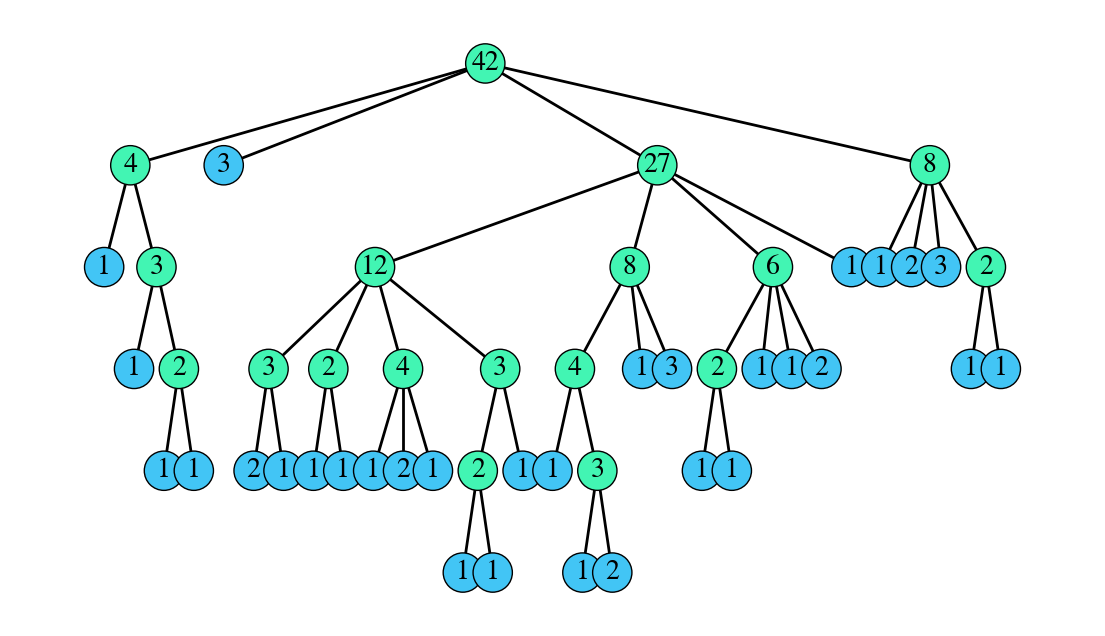

In [32]:
import random

# set random seed for reproducibility  
random.seed(1) # current version
# random.seed(7) #7 #98 #97

partition = hierarchical_partition_full(42, 4)

# # Example partition
# partition = [[[[1,1,0,0],1,0,0],[1,[[1,[1,1,0,0],0,0],[1,1,1,0],0,0],0,0],2,0],[3,[1,1,0,0],0,0]
#              ,[[[1,1,0,0],[1,1,0,0],[2,[1,2,0,0],[3,[2,1,1,0],0,0],0],1],4,[[1,1,0,0],2,0,0],0],0]

# partition = [[0, [0, [0, [0, [0, 1, 1, 0], 0, 1], 0, [1, [0, 1, 1, 0], 1, 0]], 0, 1], [0, 1, 1, 0], 0], 12, [[[0, 1, 0, 1], [[0, 1, 1, 0], 0, 1, [0, [1, 0, 1, 1], 2, 0]], 0, [1, 1, 1, 0]], [1, [1, 0, 1, 0], 0, 0], 0, 1], [0, [0, 1, 1, 0], 0, 1]]

# Build the tree
root = print_partition(partition)

# Traverse the tree
nodes, edges = traverse_tree(root)

# Get positions
pos = get_positions(root)

# Plot the tree
plot_tree(nodes, edges, pos, edge_width=2.0)

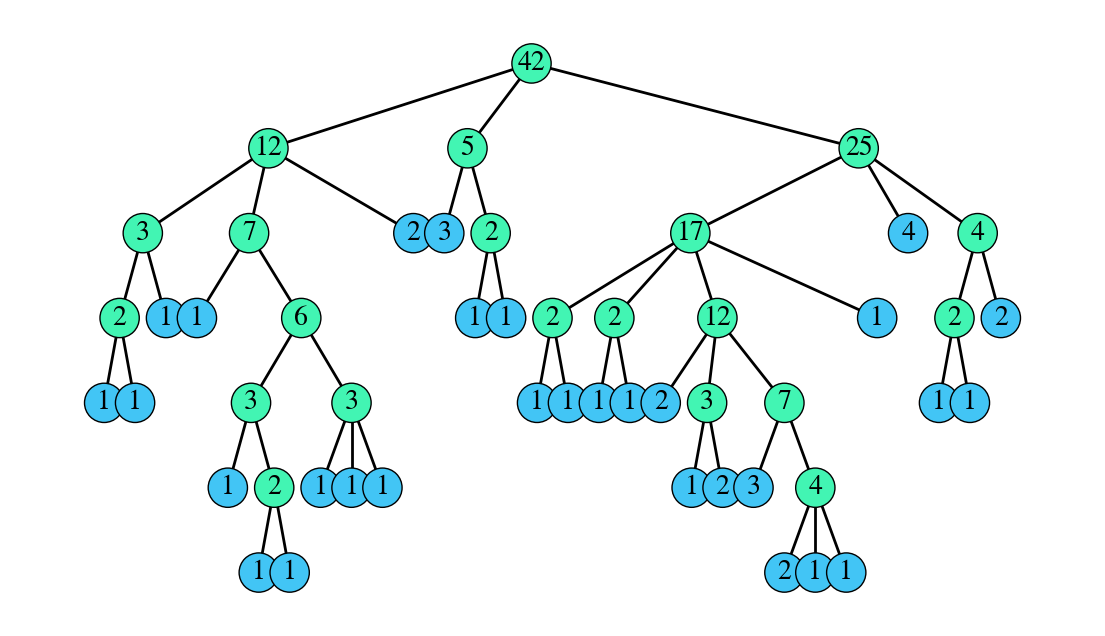

In [33]:
partition = [[[[1,1,0,0],1,0,0],[1,[[1,[1,1,0,0],0,0],[1,1,1,0],0,0],0,0],2,0],[3,[1,1,0,0],0,0]
             ,[[[1,1,0,0],[1,1,0,0],[2,[1,2,0,0],[3,[2,1,1,0],0,0],0],1],4,[[1,1,0,0],2,0,0],0],0]

# Build the tree
root = print_partition(partition)

# Traverse the tree
nodes, edges = traverse_tree(root)

# Get positions
pos = get_positions(root)

# Plot the tree
plot_tree(nodes, edges, pos, edge_width=2.0)